In [11]:
import matplotlib.pyplot as plt
import numpy as np
import Geodesics as gd
import Model as md
import cmath as cmt
import glob
import os
import time
from scipy.optimize import curve_fit as cf

In [84]:
def isBetween(z0,z1,z2):
    cross10 = z1.real*z0.imag-z0.real*z1.imag
    cross12 = z1.real*z2.imag-z2.real*z1.imag
    cross20 = z2.real*z0.imag-z0.real*z2.imag
    cross21 = -z1.real*z2.imag+z2.real*z1.imag
    isBe = (cross10*cross12) >= 0 and (cross20*cross21) >= 0
    return isBe

def entanglement_entropy(model, blackHoleRad, freq = 1):
    borderCenters = model.centers[model.border]
    borderNeigh = np.array(borderCenters[model.borderNeigh])
    wedges = np.zeros(len(borderCenters))
    validGeodesics =[g for g in model.geodesicList if g.distanceToOrigin > blackHoleRad]
    for idx,z1 in enumerate(borderCenters):
        if idx%freq==0:
            start = time.time()
            for idx2,z2 in enumerate(borderNeigh[idx,:]):
                for g in validGeodesics:
                    x = isBetween(g.endpoints[0],z1,z2) 
                    y = isBetween(g.endpoints[1],z1,z2)
                    if bool((x and not y) or (not x and y)):
                        wedges[idx2] += 1
            end = time.time()
            print('Computing entropy. Time remaining: ' + str(round((end-start)*(len(borderCenters)/freq-idx/freq)/60,4))+' m'+' '*100, end = '\r')
    wedges[int(len(borderCenters)/2):] = wedges[(int(len(borderCenters)/2)-1)::-1]
    wedges[int(len(borderCenters)/2)] = wedges[int(len(borderCenters)/2)-3]
    wedges[int(len(borderCenters)/2)-1] = wedges[int(len(borderCenters)/2)-3]
    return np.array(wedges)/len(model.border)


def geodesicsePerLength(modl):
    corr = np.zeros(len(modl.border))
    borderCenters = modl.centers[modl.border]
    for idx2,g in enumerate(modl.geodesicList):
        func = g.vect_inside()
        nums = func(borderCenters)
        idx = int(-np.sum(nums)+len(borderCenters))
        corr[int(idx/2)-1] +=1
    return corr

In [ ]:

for nlayers in range(4,5):
    #Set up model
    p = 5; q = 4
    start = time.time()
    print("Defining model with " + str(nlayers) + " layers", end = '\r')
    model = md.FractonModel(p,q,nlayers, kernel = 'SRG')
    end = time.time()
    elapsed = end-start
    nSpins = len(model.lattice)
    nGeods = len(model.geodesicList)
    print("Finished defining model with " + str(nlayers) + " layers. It took: " + str(round(elapsed,2)) + ' s'+' There are '+str(nSpins)+ ' sites and '+str(nGeods) + ' geodesics' +' '*100)
    #Lattice parameters
    nDecorr = 10 #Steps to decorrelate  
    nMeasurements = nGeods*250 #Number of measurements
    saveFreq = 1000 #Save frequency
    
    # Define the directory where you want to save the files
    save_dir = "../Data/P"+str(p)+"Q"+str(q)+"/"+str(nlayers)+"Layers"
    timeSeries_dir = save_dir+'/Correlations'
    # Check if the directory exists, if not, create it
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        os.makedirs(timeSeries_dir)

    #Number of spins in the border
    nBorder = len(model.border)
    distances = np.linspace(1,int(nBorder/2), int(nBorder/2))

    #Initialize correlation and states arrays
    corr = np.zeros(int(len(model.border)/2))
    corrTimeSeries = np.zeros((saveFreq,int(len(model.border)/2)))
    
    
    #Initialize save counter
    saveCounter = 0
    elapsed = 0
    freq = 1
    if nlayers > 5:
        freq = 10
    

    ##EntanglementEntropy
    start = time.time()
    ent_entr = entanglement_entropy(model,freq = freq)
    end = time.time()
    print('Entropy took: ' + str(round(end-start,2)) + ' s' + ' '*1000, end = '\n')
    borderCenters = model.centers[model.border]
    blockSizes = np.linspace(1,nBorder,nBorder)
    np.save(os.path.join(save_dir, "EntanglEntr.npy"),ent_entr)
    figEntr,axEntr = plt.subplots()
    axEntr.set_title("Entropy Layers = " + str(nlayers))
    axEntr.plot(blockSizes,ent_entr)
    axEntr.set_ylabel(r'$E_l$')
    axEntr.set_xlabel(r'$l$')
    axEntr.set_xscale('log')
    figEntr.savefig(os.path.join(save_dir, "EntanglEntr.eps"), format = 'eps', bbox_inches = 'tight', pad_inches = 0)

    #Simulation main loop

    for iteration in range(nMeasurements):
        start = time.time()
        model.decorrelate(nDecorr)
        temp = np.array(model.getBorderCorrelations()/nBorder)
        corrTimeSeries[saveCounter,:] = temp/nMeasurements
        corr += temp/nMeasurements
        saveCounter += 1
        end = time.time()
        elapsed += end - start
        if(saveCounter == saveFreq):
            print('Computing correlation. \tPercentage: ' + str(round(iteration/nMeasurements*100)) + '% \t' + str(round(iteration/elapsed)) + ' it/s' + '\t Time remaining: ' + str(round((elapsed*(nMeasurements-iteration)/iteration)/60,2)) +' min     ', end = '\r')
            np.save(os.path.join(save_dir, "Correlation" + ".npy"),np.array(corr))
            np.save(os.path.join(timeSeries_dir, "CorrelationTimeSeries"+str(int(iteration/saveFreq)) + ".npy"),np.array(corrTimeSeries))
            saveCounter = 0
    print('Correlation took: ' + str(round(elapsed,2))+' s'+' '*1000, end = '\n')

    figCorr, axCorr = plt.subplots()
    axCorr.set_title("Correlation Layers = " + str(nlayers))
    axCorr.plot(distances,corr/nMeasurements)
    axCorr.set_ylabel(r'$\left< e_ne_{n+d} \right>$')
    axCorr.set_xlabel(r'$d$')
    figCorr.savefig(os.path.join(save_dir, "CorrelationFigure.eps"), format = 'eps', bbox_inches = 'tight', pad_inches = 0)


    gedsPerLength = geodesicsePerLength(model)
    np.save(os.path.join(save_dir, "NumGeods.npy"),geodesicsePerLength)

In [81]:
model = md.FractonModel(5,4,5)
bHoleRads = list(set([np.round(g.distanceToOrigin,6)+0.000003 for g in model.geodesicList]))
ent_entropy = np.zeros((len(bHoleRads),int(len(model.border))))

In [85]:
for idx,r in enumerate(bHoleRads):
    ent_entropy[idx,:] = entanglement_entropy(model,r)
    print("Finished " + str(idx) + "th round."+ ' '*100, end = '\n')

Finished 0th round.                                                                                                                            
Finished 1th round.                                                                                                                            
Finished 2th round.                                                                                                                            
Finished 3th round.                                                                                                                            
Finished 4th round.                                                                                                                            
Finished 5th round.                                                                                                                            
Finished 6th round.                                                                                                                     

In [229]:
test = np.zeros((1+len(bHoleRads),int(len(model.border))))
test[0,:] = entanglement_entropy(model,0.001)
test[1:,:] = ent_entropy

In [264]:
def analyticalEntropy(x,a,b,d,temp):
    return a*np.log(x)-(b**2)*np.power(x,2)*(temp**2)+d

In [250]:
growingEntr = []
indices = []

for r in range(len(bHoleRads)+1):
    for l in range(len(test[r,:])):
        if test[r,l] == test[r,l+1]:
            growingEntr.append(test[r,:l])
            break

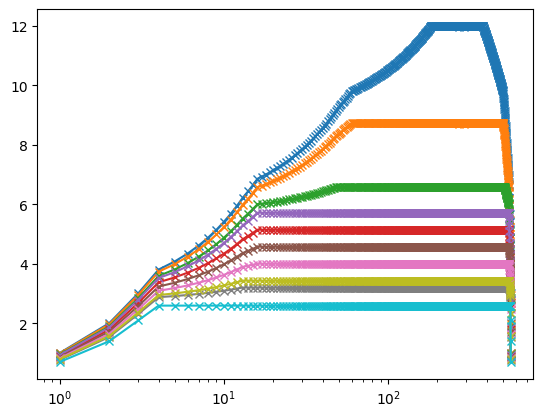

In [271]:
for idx in range(10):
    plt.plot(blockSizes,test[idx,:],'x-')
plt.xscale('log')

[ 2.17599487 -0.00329682  0.60954257  0.53191288]
[ 1.93460882 -0.01627933  0.87919031  0.40259027]
[ 1.76986885 -0.18451026  0.9296657   0.13455729]
[ 1.56636215  0.90057612  0.90636248 -0.03141035]
[1.69488622e+00 9.02592188e-01 8.86879677e-01 2.05083464e-06]
[ 1.48155686  0.2261461   0.8901688  -0.20515115]
[ 1.39675156  0.83688003  0.87397512 -0.07073955]


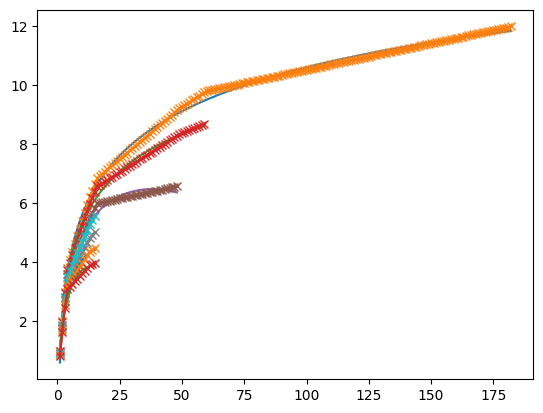

In [272]:
blockSizes = np.linspace(1,len(model.border),len(model.border))
temps = []
for r in range(0,7):
    par,pcov= cf(analyticalEntropy,blockSizes[:len(growingEntr[r])],growingEntr[r],p0 = [1.5,0.54,1,0.45])
    plt.plot(blockSizes[:len(growingEntr[r])],analyticalEntropy(blockSizes[:len(growingEntr[r])],*par))
    plt.plot(blockSizes[:len(growingEntr[r])],growingEntr[r],'x-')
    print(par)
    temps.append(np.abs(par[-1]))


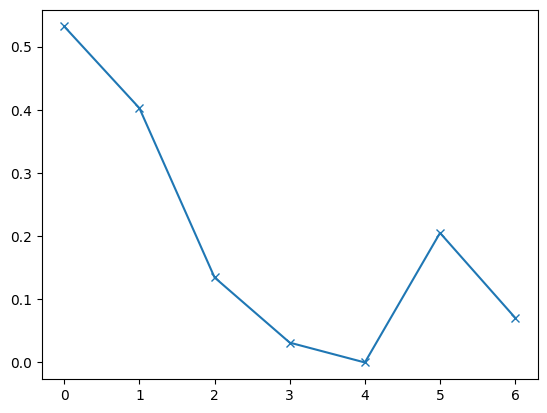

In [273]:
plt.plot(temps,'x-')
